<a href="https://colab.research.google.com/github/Audeon/fastai_Notebooks/blob/main/Chapter_2_Bear_Scare!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Chapter the book has me building a bear classification thing. This will determine between black bears, grizly bears, and teddy bears.
---
Lets start with all the inports and enviromental stuff.

In [ ]:
%env AZURE_KEY=003933db7805494c85e70fa57e2b2319 # Dead Key 

env: AZURE_KEY=003933db7805494c85e70fa57e2b2319


In [ ]:
!pip install -q fastai --upgrade

In [ ]:
!pip install -q fastbook --upgrade

In [ ]:
from os import environ

In [ ]:
from fastbook import *

In [ ]:
from fastai import *

Now that the imports are done we are going to grab our Azure API key from the enviromental variable.

In [ ]:
azure_key = environ.get("AZURE_KEY")

Using fastbooks.search_images_bing() we use our API key to create ab image search of grizly bears on bing.

In [ ]:
results = search_images_bing(azure_key, "grizzly bear")

Then we will get the urls for the images into a list.

In [ ]:
ims = results.attrgot('contentUrl')

Lets see how many we actually got. You should see 150 as a result. This is because bing image search will only let you get 150 results per query. However you can make mutiple quries to continue to build the list but that is not part of this chapter or scope. Laterrrrr.

In [ ]:
len(ims)

150

Lets download and display one of the examples just to see what kind of bears we are getting. You can alter the download_url(ims[X], dest) where X is any image url in the list.


In [ ]:
dest = 'images/grizzly.jpg'

In [ ]:
download_url(ims[23], dest)

Path('images/grizzly.jpg')

In [ ]:
im = Image.open(dest)

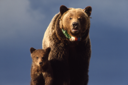

In [ ]:
im.to_thumb(128,128)

---
Now lets get all of the images we are going to use. grizzly bear, black bear, and teddy bear, and polar bear


In [ ]:
bear_types = ["grizzly", "black", "polar", "teddy"]

In [ ]:
path = Path('bears')

In [ ]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    print(f"{o} bear")
    dest = (path/o)
    print(dest)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(azure_key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))

Verifying that the images are actually in the correct folders.

In [ ]:
fns = get_image_files(path)

In [ ]:
print(fns)

[Path('bears/polar/00000124.jpg'), Path('bears/polar/00000038.jpg'), Path('bears/polar/00000095.jpg'), Path('bears/polar/00000100.jpg'), Path('bears/polar/00000058.jpg'), Path('bears/polar/00000080.jpg'), Path('bears/polar/00000010.jpg'), Path('bears/polar/00000146.jpg'), Path('bears/polar/00000128.jpg'), Path('bears/polar/00000056.jpg'), Path('bears/polar/00000130.jpg'), Path('bears/polar/00000117.jpg'), Path('bears/polar/00000035.jpg'), Path('bears/polar/00000037.jpg'), Path('bears/polar/00000051.jpg'), Path('bears/polar/00000011.jpeg'), Path('bears/polar/00000017.jpg'), Path('bears/polar/00000106.jpg'), Path('bears/polar/00000041.jpg'), Path('bears/polar/00000143.jpg'), Path('bears/polar/00000031.jpg'), Path('bears/polar/00000132.jpg'), Path('bears/polar/00000022.jpg'), Path('bears/polar/00000043.jpg'), Path('bears/polar/00000046.jpg'), Path('bears/polar/00000135.jpg'), Path('bears/polar/00000083.jpg'), Path('bears/polar/00000136.jpg'), Path('bears/polar/00000103.jpeg'), Path('bears

---
Now we are going to identify and unlink any failed or corrupted images.


In [ ]:
failed = verify_images(fns)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
print(failed)

[]


In [ ]:
failed.map(Path.unlink)

(#0) []



---


Now we are going to build the data block. Datablocks are used for customizing your dataloaders, that is the thing used to train your models. It does thins such as getting the location of the data files, method of splitting data into its various types (Train, Validation, Testing, etc). As well as labels. Using this method is best for when you have more or less unorganized data. 

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [ ]:
dls = bears.dataloaders(path)

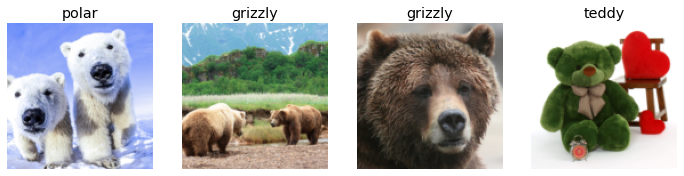

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

By default resize wil crop images to fit a square shape as seen above. Lets take a look at what happens when we use squish instead.

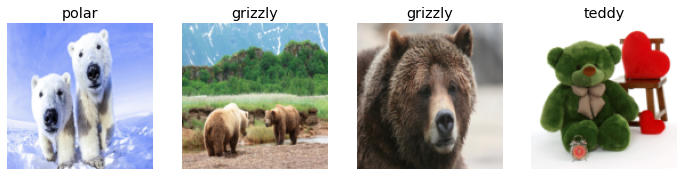

In [ ]:
bears =  bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

See there is more data with the Squish method than there is just the square crop. Losing data with a square crop means you may miss important details. While the squashed method will alter the images and may teach the model to identify squashed images.

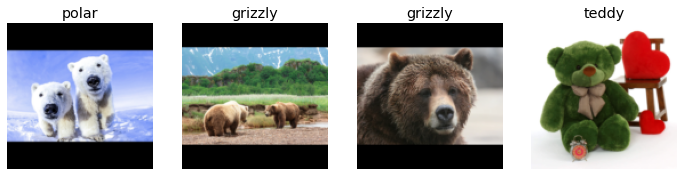

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Finally we see the added images. In this case you keep the data and the aspect ratio intact, but you have the additional computation of the padding of zeros on the top and bottom of some images.

In reality we take a partial crop a small randomly selected subsection of the image to sample for that epoch. Each epoch uses a differnt sampled subsection. This has the usfulness of not distoring our image or losing data. Additionally this helps the model focus on individual portions of the image which will later help better identify those objects when they are in differnt positions/lighting etc.

Lets set that up now.

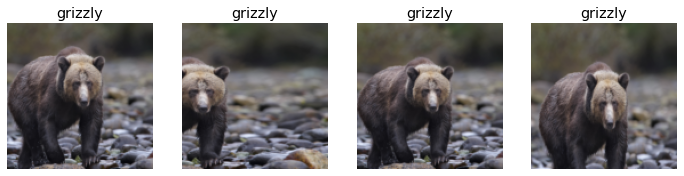

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)



---


**Data Augmentation** refers to creating random variations in the input data such that they appear differntly but do not change the meaning of the data. Such data augmentation of images includes: roation, brighten, skew, contrast adjust, flipping.





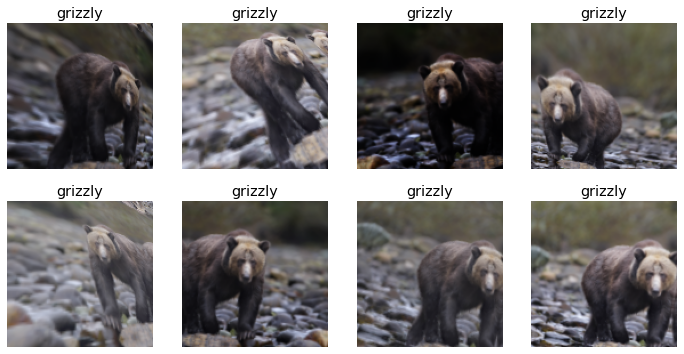

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)



---


OKay enough playing with differnt transformers. Lets move onto Training a model then using it to clean the data. We will use the RandomResizeCrop for the transform, apply some basic augmentation as shown above, then load the data into a dataloader before we pass it to a CNN for training.

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


Now we creat the learner object and then fine tune it. 

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [ ]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.352630,0.091946,0.025862,00:39


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,0.129734,0.067985,0.017241,00:39
1,0.087272,0.103493,0.017241,00:40
2,0.060862,0.109955,0.017241,00:40
3,0.049476,0.104535,0.017241,00:40


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.w

Now that we have our model trained, lets check and see what kind of mistakes the model is making in identifying the different types of bears.

In [ ]:
iinterp = ClassificationInterpretation.from_learner(learn)

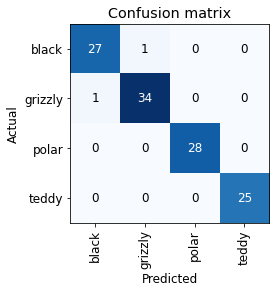

In [ ]:
iinterp.plot_confusion_matrix()

The rows and columns represent the types of bears in our data set. On the x-axis we have the predictied values, and on the y-access we have the actual values. As you can see, in one instance the model predicted a grizzly bear was a black bear, and a black bear was a grizzly bear. We can probably excuse this because we are not confusing either with a teddy bear and certainly not a polar bear. 

This type of data is good to determine how your model is behaving, and furthur tune it by cleaning. Lets take a look at the top losses and find out what they were.

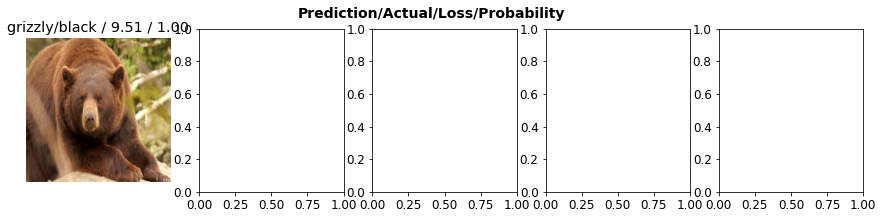

In [ ]:
iinterp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierClearner(learn)

This part is broken due to colab. Maybe we should find an alternative. 



---

Now we will export our model in order to prepare it to use in other applications. Remember the model is essentially just a very very complex program with inputs and outputs. This means you can work with it like a normal program.

In [ ]:
learn.export()